In [2]:
#เตรียมการ library
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 30
fill_flag = 8 | ( 255 << 8 )
print(cv2.__version__)

3.3.0


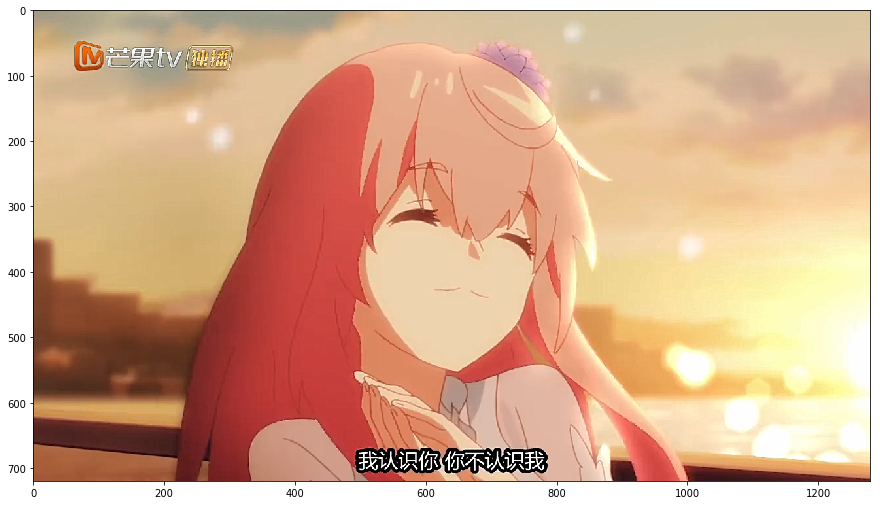

In [3]:
#โหลดรูปภาพต้นฉบับ
ori_image = cv2.imread("../images/testsubtitle_1.jpg")
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB) # cv2 use bgr but plt use rgb
plt.imshow(ori_image)
plt.show()

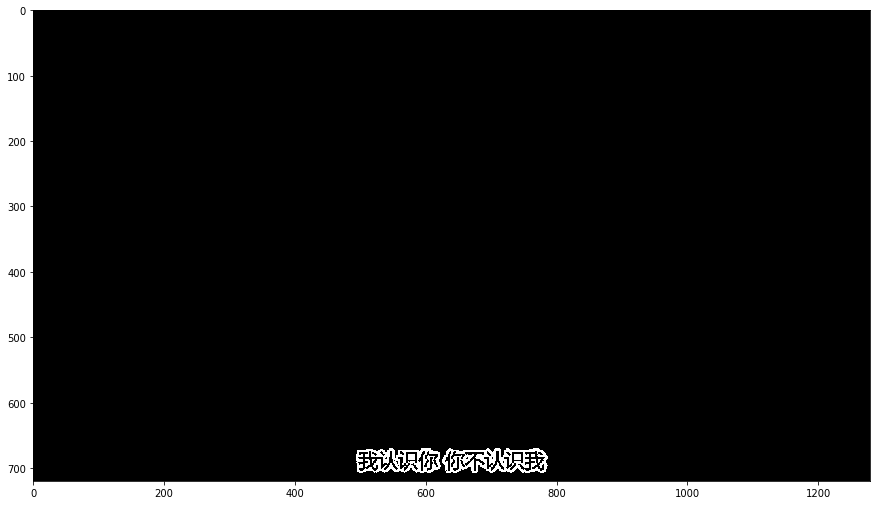

In [7]:
black_mask = cv2.inRange(ori_image, (0,0,0), (20,20,20))
plt.imshow(black_mask,cmap = plt.cm.gray)
plt.show()

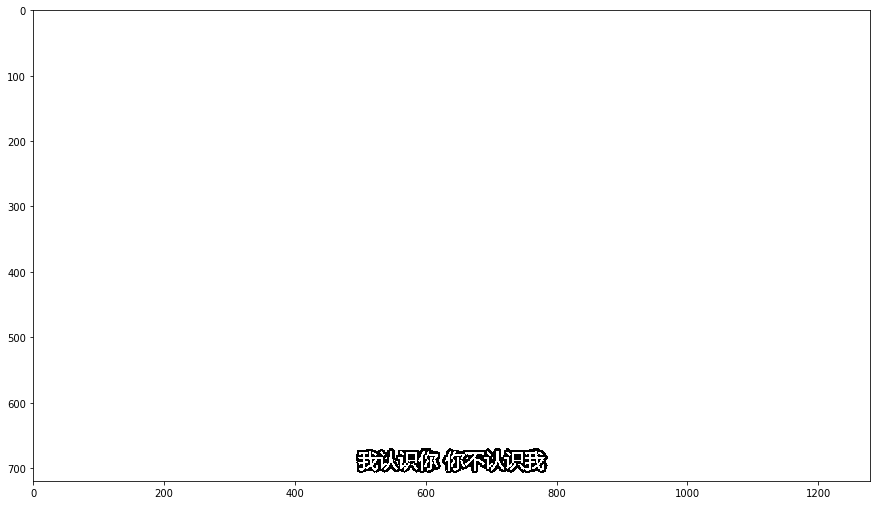

In [8]:
#สลับสีเพื่อเตรียมการเคลียของทิ้ง
black_fill_mask = cv2.bitwise_not(black_mask)
plt.imshow(black_fill_mask,cmap = plt.cm.gray)
plt.show()

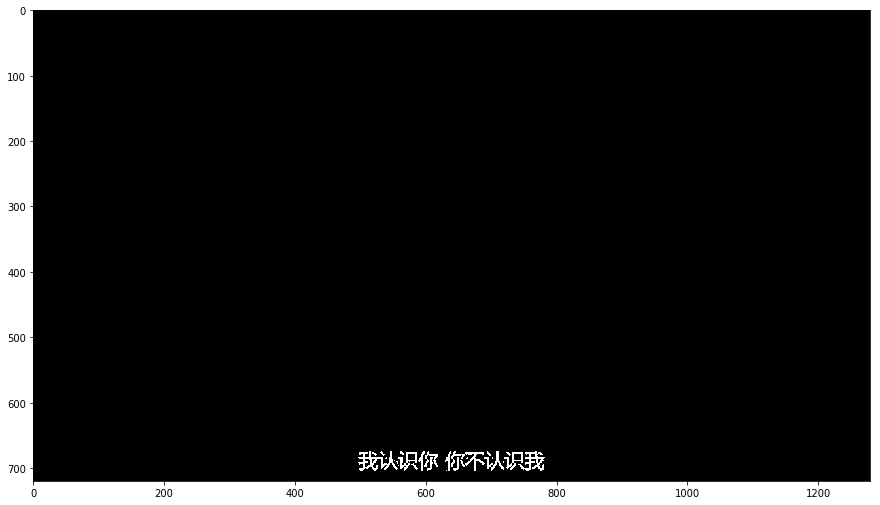

In [9]:
#ทำการถมดำ
cavity_mask = black_fill_mask.copy()
height,width = black_fill_mask.shape
mask_flood = np.zeros((height+2, width+2), np.uint8) #require by OpenCV spec but doesn't not affact
for y in range(0,height):
    cv2.floodFill(cavity_mask,mask_flood,(0,y),0)
    cv2.floodFill(cavity_mask,mask_flood,(width-1,y),0)
for x in range(0,width):
    cv2.floodFill(cavity_mask,mask_flood,(x,0),0)
    cv2.floodFill(cavity_mask,mask_flood,(x,height-1),0)
plt.imshow(cavity_mask,cmap = plt.cm.gray)
plt.show()

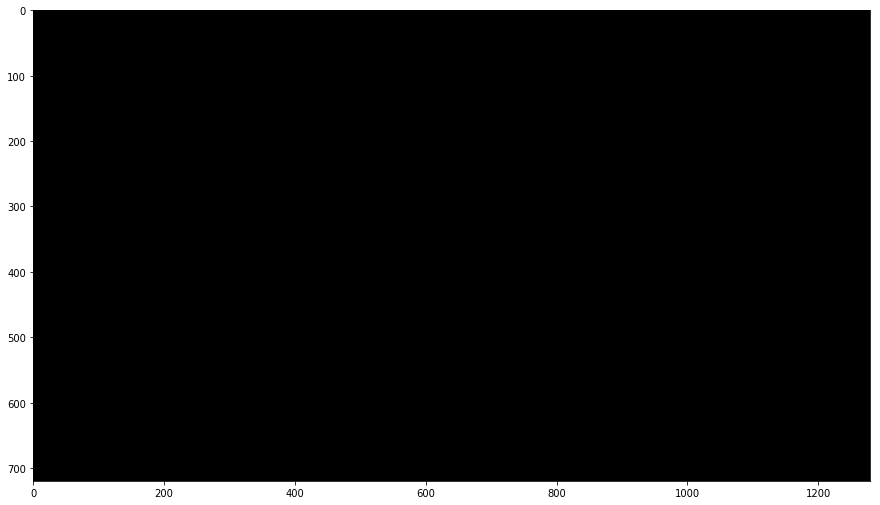

In [10]:
#หาพื้นที่ใหญ่เกินไปในภาพ
large_object = cv2.erode(cavity_mask,np.ones((7,7)))
plt.imshow(large_object,cmap = plt.cm.gray)
plt.show()

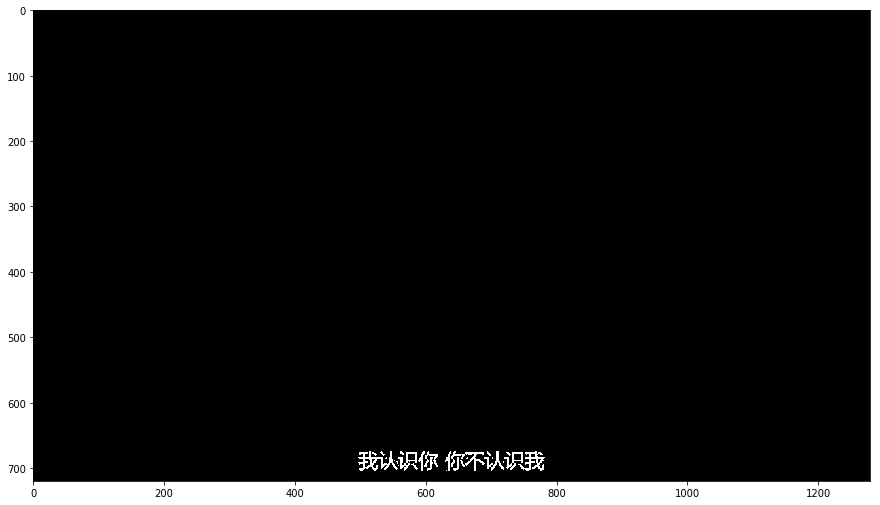

In [11]:
#ถมวัตถุที่ใหญ่เกินไป
mask_flood_object = np.zeros((height+2, width+2), np.uint8) 
mask_flood_canvas = np.zeros((height+2, width+2), np.uint8) 
large_object_canvas = large_object.copy()
cavity_with_noise = cavity_mask.copy()
for y in range(0,height):
    for x in range(0,width):
        if large_object_canvas[y][x] == 255:
            cv2.floodFill(large_object_canvas,mask_flood_object,(x,y),0)
            cv2.floodFill(cavity_with_noise,mask_flood_canvas,(x,y),0)
plt.imshow(cavity_with_noise,cmap = plt.cm.gray)
plt.show()

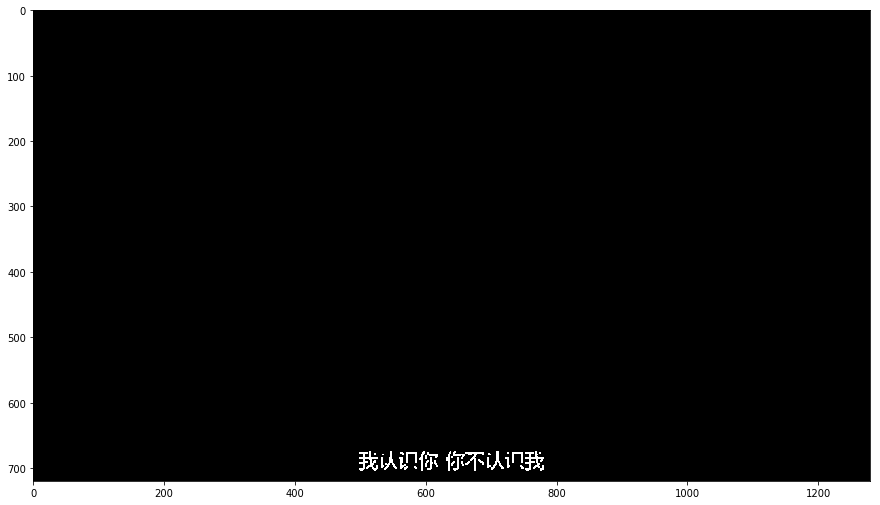

In [12]:
#ลบพื้นที่เล็กเกินไปออกจากภาพ
cavity_no_noise = cv2.morphologyEx(cavity_with_noise, cv2.MORPH_OPEN, np.ones((3,3)))
plt.imshow(cavity_no_noise,cmap = plt.cm.gray)
plt.show()

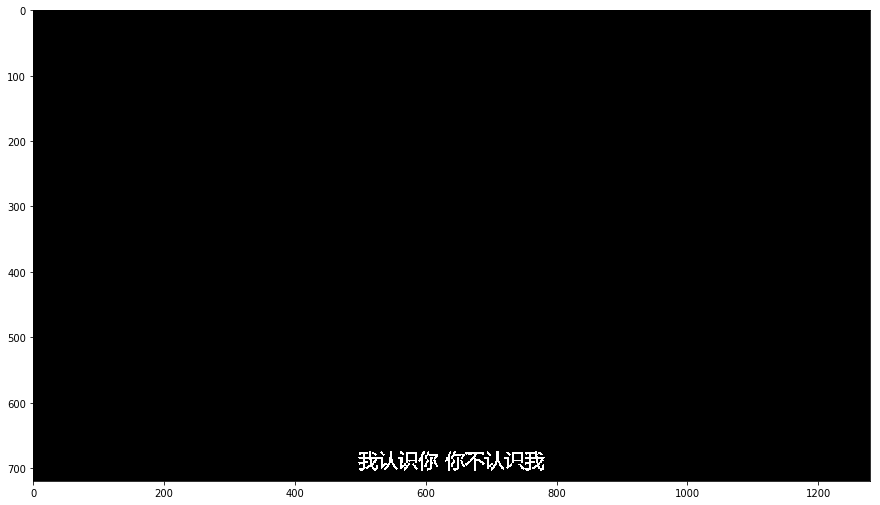

In [13]:
#ใช้ connected component labeling เพื่อเอาส่วนที่ต้องการโดยไม่ให้ตัวอักษรเสียหายมากนัก
nonoise = cavity_no_noise.copy()
noisy = cavity_with_noise.copy()
mask_flood_nonoise = np.zeros((height+2, width+2), np.uint8) 
mask_flood_noisy = np.zeros((height+2, width+2), np.uint8) 
for y in range(0,height):
    for x in range(0,width):
        if nonoise[y][x] == 255:
            cv2.floodFill(nonoise,mask_flood_nonoise,(x,y),0)
            cv2.floodFill(noisy,mask_flood_noisy,(x,y),0)
result_mask = mask_flood_noisy[1:height+1,1:width+1]
plt.imshow(result_mask,cmap = plt.cm.gray)
plt.show()

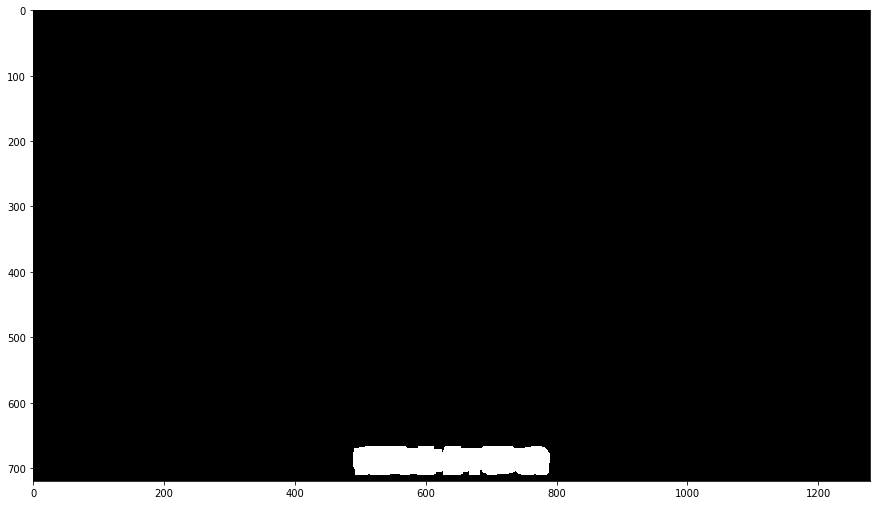

In [14]:
subtitle_stoke = cv2.dilate(result_mask,np.ones((15,15)))
plt.imshow(subtitle_stoke,cmap = plt.cm.gray)
plt.show()

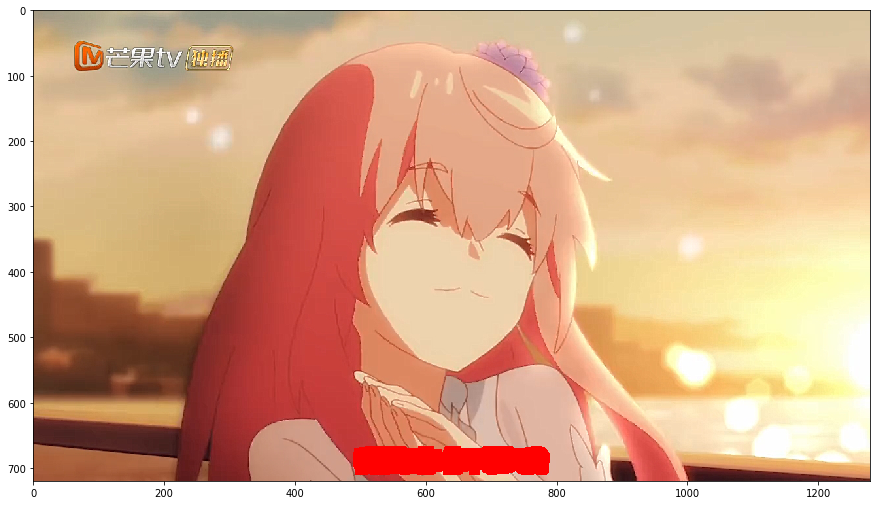

In [15]:
#ตัวอย่าง ผสานปภาพ
lay_img = ori_image.copy()
for y in range(0,height):
    for x in range(0,width):
        if subtitle_stoke[y][x] == 1:
            lay_img[y][x][0] = 255
            lay_img[y][x][1] = 0
            lay_img[y][x][2] = 0
plt.imshow(lay_img)
plt.show()

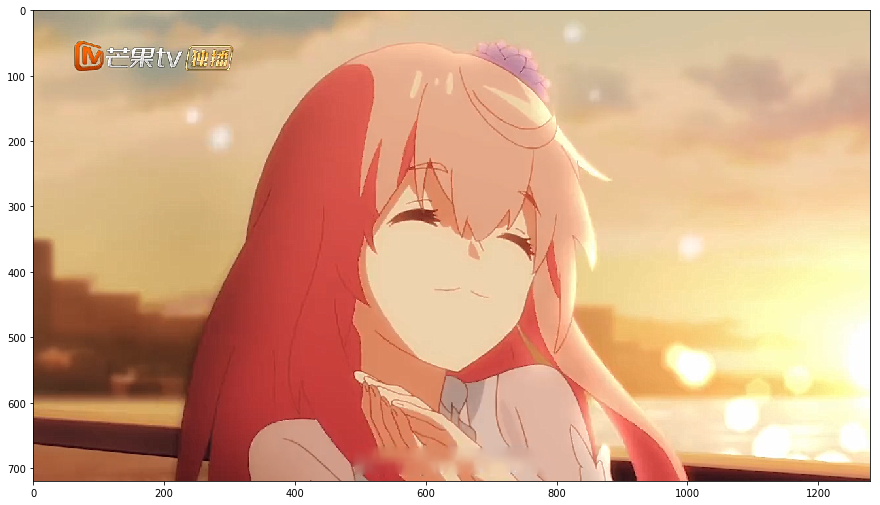

In [16]:
tofix_image = ori_image.copy()
fixed_image = cv2.inpaint(tofix_image,subtitle_stoke,20,cv2.INPAINT_TELEA)
plt.imshow(fixed_image)
plt.show()

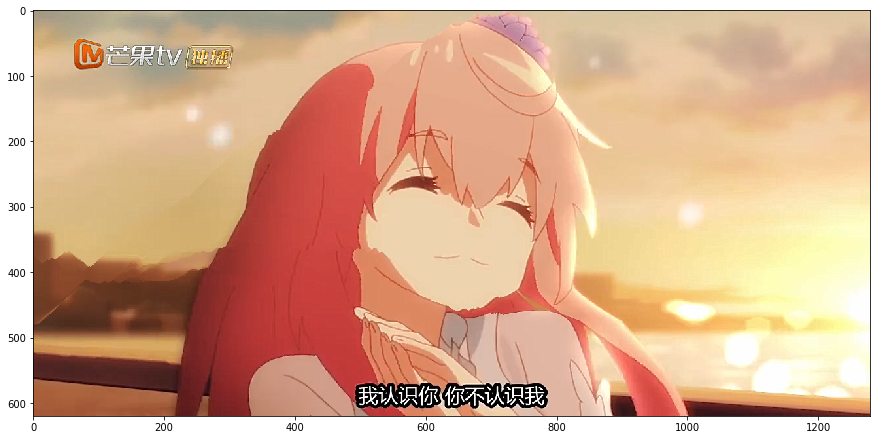

In [29]:
#SEAM CAVING
from skimage import data, draw
from skimage import transform, util
from skimage import filters, color
img = util.img_as_float(ori_image)
eimg = filters.sobel(color.rgb2gray(img))
poly = [(670,480),(710,480),(710,800),(670,800)]
hl_color = np.array([0, 1, 0])
pr = np.array([p[0] for p in poly])
pc = np.array([p[1] for p in poly])
rr, cc = draw.polygon(pr, pc)
masked_img = img.copy()
masked_img[rr, cc, :] = masked_img[rr, cc, :]*0.5 + hl_color*.5
eimg[rr, cc] -= 1000
out = transform.seam_carve(img, eimg, 'horizontal', 100)
#resized = transform.resize(img, out.shape, mode='reflect')
plt.imshow(out)
plt.show()

In [ ]:
print(eimg[670][600])